In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chess
import re
import tensorflow as tf


In [8]:
chessData = pd.read_csv('./chessData.csv')
chessData = chessData.head(100000)
chessData

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
99995,rq2r1k1/3n1ppp/4pn2/p2p4/1p1P4/PPNQ2P1/4PPNP/2...,+54
99996,rq2r1k1/3n1ppp/4pn2/pN1p4/1p1P4/PP1Q2P1/4PPNP/...,-3
99997,rqr3k1/3n1ppp/4pn2/pN1p4/1p1P4/PP1Q2P1/4PPNP/2...,+34
99998,rqr3k1/3n1ppp/4pn2/pN1p4/Pp1P4/1P1Q2P1/4PPNP/2...,+17


In [3]:
def strfix(fen, tr):
    
    fstr = str(fen)
    
    if '#' in str(tr):
        if '-' in tr:
            t = -10000
        else:
            t = 10000
    elif '\ufeff+23' in str(tr):
        t = 0
    else:
        t = int(tr)
    if "b" in fstr:
        t = t*-1
    t = t/10

    return t

In [4]:
def pieces_to_bits(boardstr):
    for i, char in enumerate(boardstr):
        if char == 'P':
            boardstr = boardstr.replace(char, "|1")
        elif char == 'p':
            boardstr = boardstr.replace(char, "|-1")
        elif char == 'N':
            boardstr = boardstr.replace(char, "|3")
        elif char == 'n':
            boardstr = boardstr.replace(char, "|-3")
        elif char == 'B':
            boardstr = boardstr.replace(char, "|4")
        elif char == 'b':
            boardstr = boardstr.replace(char, "|-4")
        elif char == 'Q':
            boardstr = boardstr.replace(char, "|9")
        elif char == 'q':
            boardstr = boardstr.replace(char, "|-9")
        elif char == 'K':
            boardstr = boardstr.replace(char, "|100")
        elif char == 'k':
            boardstr = boardstr.replace(char, "|-100")
        elif char == 'R':
            boardstr = boardstr.replace(char, "|5")
        elif char == 'r':
            boardstr = boardstr.replace(char, "|-5")
        elif char == '.':
            boardstr = boardstr.replace(char, "|0")
    boardstr = boardstr.replace("'", " ")
    boardstr = boardstr.replace("|", ",")
    boardstr = boardstr.replace("\n", "")
    boardstr = boardstr.replace(" ", "")
    boardstr = boardstr[1:]
    boardstr = eval(boardstr)
    boardstr = list(boardstr)

    return boardstr

In [5]:
def board_to_bits(fen):
    components = re.split(" ", fen[0])
    turn = components[1]
    castlingRights = components[2]
    enPassant = components[3]
    board = chess.Board(fen[0])
    boardString = str(board)

    boardString = pieces_to_bits(boardString)
    # print(boardString)

    if 'K' in castlingRights:
        WCK = 1
    else:
        WCK = 0
    if 'Q' in castlingRights:
        WCQ = 1
    else:
        WCQ = 0
    if 'k' in castlingRights:
        BCK = 1
    else:
        BCK = 0
    if 'k' in castlingRights:
        BCQ = 1
    else:
        BCQ = 0
    blackAux = [BCK, BCQ]
    whiteAux = [WCK, WCQ]
    
    if "w" not in turn:
        for i in range(len(boardString)):
            boardString[i] = -1*boardString[i]
        temp = blackAux
        blackAux = whiteAux
        whiteAux = temp


    return blackAux + whiteAux + boardString

In [6]:
temp = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1"
print(board_to_bits([temp,0]))

[1, 1, 1, 1, 5, 3, 4, 9, 100, 4, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, -1, -1, -1, -5, -3, -4, -9, -100, -4, -3, -5]


In [9]:
FENMatrix = chessData.drop(columns=chessData.iloc[:, [1]])
FENMatrix = FENMatrix.apply(board_to_bits, axis=1)
FENMatrix = FENMatrix.apply(pd.Series)

inputboard = np.array(FENMatrix.drop(columns=FENMatrix.iloc[:, [0, 1, 2, 3]]))
print(inputboard)
# inputboard = np.array(inputboard)

tempData = chessData
tempData.columns = ['fen', 'eval']

data_labels = tempData.astype(str)
data_labels = tempData.apply(lambda x: strfix(x['fen'], x['eval']), axis=1)

print(data_labels)

[[   5    3    4 ...   -4   -3   -5]
 [  -5   -3   -4 ...    4    3    5]
 [   5    3    4 ...   -4   -3   -5]
 ...
 [  -5   -9   -5 ...    0  100    0]
 [   5    9    5 ...    0 -100    0]
 [  -5    0    0 ...    5  100    0]]
0        1.0
1       -5.6
2        0.9
3       -5.2
4        2.6
        ... 
99995    5.4
99996    0.3
99997    3.4
99998   -1.7
99999   -5.4
Length: 100000, dtype: float64


In [10]:
inputmeta = np.array(FENMatrix.iloc[:, [0, 1, 2, 3]])
inputmeta

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0]], dtype=int64)

In [11]:
input1 = tf.keras.layers.Input(shape=(64,))
shape1 = tf.keras.layers.Reshape(target_shape=(8, 8, 1))(input1)
conv1 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,1))(shape1)
bn1 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv1)
conv2 = tf.keras.layers.Conv2D(kernel_size=(8,8), padding="same", activation="relu", filters=64, input_shape=(8,8,1))(bn1)
bn2 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv2)
flatten1 = tf.keras.layers.Flatten()(bn2)
input2 = tf.keras.layers.Input(shape=(4,))

conc = tf.keras.layers.concatenate([flatten1,input2])

Denselayer1 = tf.keras.layers.Dense(1024, activation='relu')(conc)
Denselayer2 = tf.keras.layers.Dense(512, activation='relu')(Denselayer1)
Denselayer3 = tf.keras.layers.Dense(256, activation='relu')(Denselayer2)
Denselayer4 = tf.keras.layers.Dense(256, activation='relu')(Denselayer3)
Output = tf.keras.layers.Dense(1, activation='linear')(Denselayer4)



data_model = tf.keras.models.Model(inputs=[input1, input2], outputs=Output)

predictions = data_model([(inputboard[:1]), (inputmeta[:1])]).numpy

metric =[tf.keras.metrics.MeanAbsoluteError()]

In [10]:
opt = tf.keras.optimizers.Adam()

los = tf.keras.losses.MeanSquaredError()

data_model.compile(optimizer=opt, 
                   loss=los,
                   metrics=metric)
data_model.summary()
data_model.fit([inputboard, inputmeta], data_labels, epochs=1, batch_size=8192, shuffle=True)
data_model.save("engine01.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     4160        ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                   

In [14]:
loaded_model = tf.keras.models.load_model("./engine01.keras")

# predictions = data_model([(inputboard[100:101]), (inputmeta[100:101])])
kek = loaded_model.predict([(inputboard[99995:99996]), (inputmeta[99995:99996])])
print((inputboard[99995:99996]), (inputmeta[99995:99996]))

1/1 [==============================] - 0s 107ms/step
[[  -5   -9    0    0   -5    0 -100    0    0    0    0   -3    0   -1
    -1   -1    0    0    0    0   -1   -3    0    0   -1    0    0   -1
     0    0    0    0    0   -1    0    1    0    0    0    0    1    1
     3    9    0    0    1    0    0    0    0    0    1    1    3    1
     0    0    5    5    0    0  100    0]] [[0 0 0 0]]


rq2r1k1/3n1ppp/4pn2/p2p4/1p1P4/PPNQ2P1/4PPNP/2RR2K1 w - - 0 21
eval for following position (WHITE TURN) 0.95907474


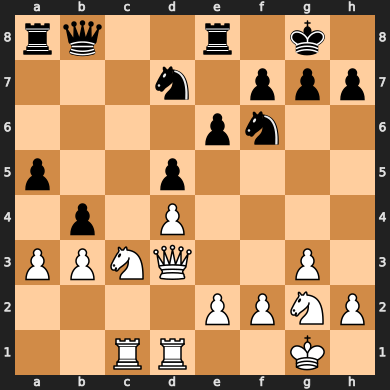

In [13]:
print(chessData["fen"][99995])
print("eval for following position (WHITE TURN)", kek[0][0])
chess.Board(chessData["fen"][99995])